# 正则化实验

本实验会给出几种神经网络中最受欢迎的正则化方法，以及用MindSpore实现：提前停止，L2正则化，dropout。此外该实验也增加了Batch Normalization归一化方法优化模型效果。

## 1、实验目的

- 掌握L2正则化，dropout、Batch Normalization归一化方法原理。
- 掌握如何使用MindSpore进行提前停止，L2正则化，dropout、Batch Normalization归一化方法的开发。

## 2、L2正则化，dropout、Batch Normalization归一化方法原理介绍

### 2.1 L2正则化

L2是在求loss的时候，加入到loss的求解过程中，得到被惩罚后的loss，再让loss对权重求导，得到更新值，最后原权重减去学习率和更新值的乘积，最终得到权重的更新值，完成反向传播过程，进行新一轮的训练。

按上述思路，可得L2正则化是模型各个参数的平方和的开方值。
$$
L = L(\omega) + \lambda \sum_{i=1}^{n}{\omega^{2}_i}
$$
$$
\frac{\vartheta L}{\vartheta \omega_{i}} = \frac{\vartheta L(\omega)}{\vartheta \omega_{i}} + 2\lambda \cdot \omega_{i}
$$

更新权重如下式所示：
$$
\omega_{i} = \omega_{i} - \eta(\frac{\vartheta L(\omega)}{\vartheta \omega_{i}} + 2\lambda \cdot \omega_{i}) = (1-2\eta \lambda)\omega_{i} - \eta (\frac{\vartheta L(\omega)}{\vartheta \omega_{i}})
$$
其中$\eta$表示学习率。

注意上式会发现，加入了L2正则化后，更新权重时$\omega_{i}$前的值会变成$1-2\eta \lambda$，而这也会让$\omega_{i}$越来越小，这里称之为权重衰减。

### 2.2 dropout

如下图所示，左边的网络存在过拟合，dropout的工作原理就是对于网络中的每一层，设置一个概率值p，p表示该层的任一节点，保留该节点的概率为p，删除它的概率为1-p。假设每一层的p为0.5，则任何一个节点有50%的概率被删除，即网络中有接近一半的节点会被删除，同时删除网络图中对应的连线。因此使用dropout之后，我们得到了一个更加精简的网络模型。
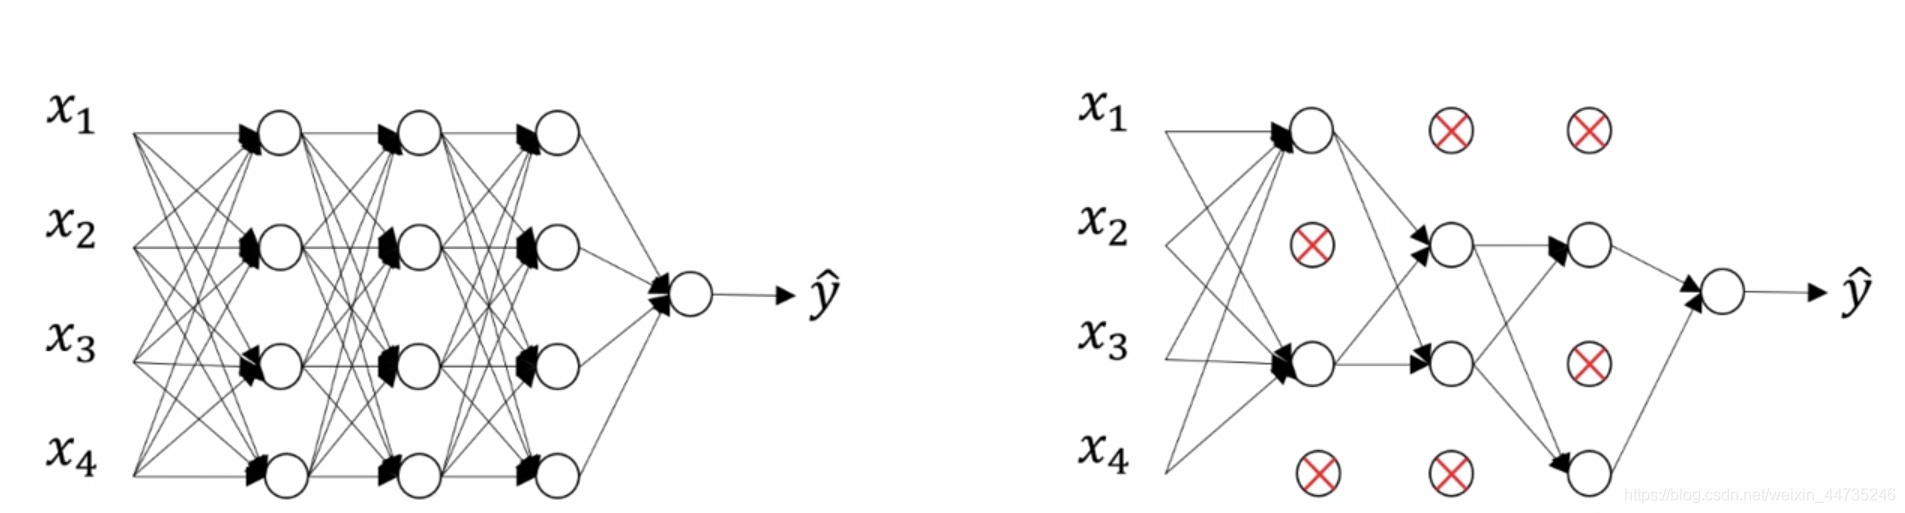

### 2.3 Batch Normalization归一化

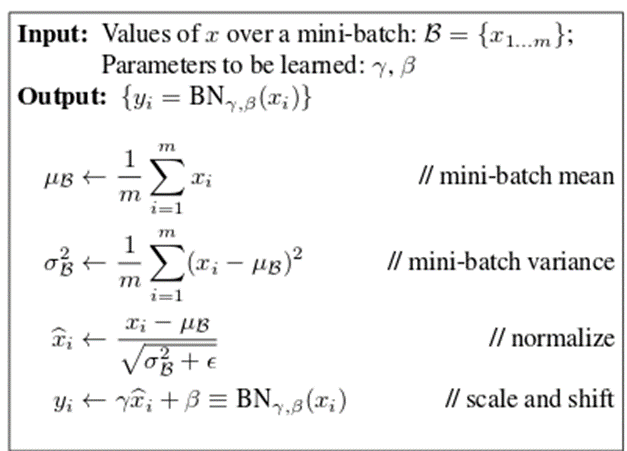



- 输入：批处理（mini-batch）输入 $x:B = \{x_1, \dots, m\}$

- 输出：规范化后的网络响应:$\{y_i=BN_\gamma,\beta(x_i)\}$

- 过程：
    - 1、计算批处理数据均值（mini-batch mean）
    - 2、计算批处理数据方差(mini-batch variance)
    - 3、规范化(normalize)： 获得$N\sim(0,1)$正态分布。其中$\varepsilon$是为了避免除数为0时所使用的微小正数。
    - 4、尺度变换和转移(scale and shift)： 将$x_{i}$乘以$\gamma$调整数值大小，再加上$\beta$增加偏移后得到$y_{i}$，这里的$\gamma$是尺度因子，$\beta$是平移因子。这一步是BN的精髓，由于归一化后的$x_{i}$基本会被限制在正态分布下，使得网络的表达能力下降。为解决该问题，我们引入两个新的参数：$\gamma$和$\beta$。$\gamma$和$\beta$是在训练时网络自己学习得到的。
    - 5、return 学习的参数

## 3、实验环境

本案例支持win_x86和Linux系统，CPU/GPU/Ascend均可运行。

如果在本地运行此实验，请参考《MindSpore环境搭建实验手册》在本地安装MindSpore。

## 4、数据处理

### 4.1数据准备

实验中所用数据集为数值型数据，输入数据data_x为在(-1,1)以等间隔生成100个数据，标签值data_y值利用余弦函数生成，其余弦函数公式如下：

$$y = \cos(x\pi)$$

其生成数据的代码为：

In [1]:
import random
import numpy as np

#固定结果
def fix_seed(seed=1):
    random.seed(seed)
    np.random.seed(seed)

#建立数据集x值，y值
fix_seed(5)
data_x = np.linspace(-1, 1, num=int(100))[:, np.newaxis]
data_y = np.cos(np.pi*data_x)
print(data_y.shape)

(100, 1)


## 4.2数据加载

数据在输入模型之前，需要对其进行格式转换，把数据处理成模型所需的维度。在处理数据之前需要引入MindSpore框架中相关的数据处理模块，以达到数据预处理的目的；另外，需要所使用的变量进行定义。

详细的MindSpore模块说明，可以在MindSpore API页面中搜索查询：https://www.mindspore.cn/docs/zh-CN/master/index.html

可以通过mindspore.set_context来配置运行需要的信息，譬如运行模式、后端信息、硬件等信息。


In [2]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

#导入mindspore框架
import mindspore as ms
#导入mindspore中Neural Networks(nn)模块，包含预先定义的构建块或计算单元来构建神经网络。
from mindspore import nn
#导入参数初始化模块
from mindspore.common.initializer import Normal
from mindspore.dataset import GeneratorDataset

# 设置MindSpore的执行模式和设备
ms.set_context(mode=ms.GRAPH_MODE, device_target='CPU')

本实验中相关参数的定义：

In [3]:
N_SAMPLES = 80               #样本数
BATCH_SIZE = 40              #批量大小
NOISE_RATE = 0.2             #噪声率
INPUT_DIM = 1                #输入维度
HIDDEN_DIM = 100             #隐藏层维度
OUTPUT_DIM = 1               #输出维度
N_LAYERS = 6                 #隐藏层数目
ITERATION = 50               #最大输入迭代
LEARNING_RATE = 0.003        #学习率
DROPOUT_RATE = 0.7
WEIGHT_DECAY = 1e-4          #L2正则化惩罚数值
MAX_COUNT = 20               #最早终止参数
ACTIVATION = nn.LeakyReLU    #激活函数

mindspore.dataset提供了部分常用数据集和标准格式数据集的加载接口。对于MindSpore暂不支持直接加载的数据集，可以通过构造自定义数据集类或自定
义数据集生成函数的方式来生成数据集，然后通过GeneratorDataset接口实现自定义方式的数据集加载。

Python中可以使用for循环遍历出所有元素的，都可以称为可迭代对象(Iterable)，我们可以通过实现__getitem__方法来构造可迭代对象，并将其加载至
GeneratorDataset。

In [4]:
#建立数据集x值，y值
fix_seed(5)
# Iterable object as input source
class Iterable:
    def __init__(self):
        self._data = np.linspace(-1, 1, num=int(100))[:, np.newaxis]
        self._label = np.cos(np.pi*data_x) + np.random.normal(0, NOISE_RATE, self._data.shape)

    def __getitem__(self, index):
        return self._data[index], self._label[index]

    def __len__(self):
        return len(self._data)

data = Iterable()
dataset_train = GeneratorDataset(source=data, num_samples=N_SAMPLES, column_names=["data", "label"])
dataset_eval = GeneratorDataset(source=data, num_samples=20, column_names=["data", "label"])

## 5、模型构建

使用MindSpore定义神经网络需要继承mindspore.nn.Cell。Cell是所有神经网络（Conv2d等）的基类。

神经网络的各层需要预先在__init__方法中定义，然后通过定义construct方法来完成神经网络的前向构造。本实验自定义神经网络，采用卷积、BatchNorm或dropout、Flatten层和Dense层，来验证各正则化方法的实验效果。

In [5]:
#自定义Cosine网络
class CosineNet(nn.Cell):
    def __init__(self, batchnorm, dropout):
        super(CosineNet, self).__init__()
        layers = []
        if batchnorm:
            layers.append(nn.BatchNorm2d(INPUT_DIM))
        
        # 初始化隐含层
        for l_n in range(N_LAYERS):
            in_channels = HIDDEN_DIM if l_n > 0 else INPUT_DIM
            # 这里使用1x1Conv代替全连接算子，可以与BatchNorm2d算子配合的更好
            conv = nn.Conv2d(in_channels, HIDDEN_DIM, kernel_size=1, pad_mode='valid', has_bias=True, weight_init=Normal(0.01))
            layers.append(conv)
            if batchnorm:
                layers.append(nn.BatchNorm2d(HIDDEN_DIM))
            if dropout:
                layers.append(nn.Dropout(DROPOUT_RATE))
            layers.append(ACTIVATION())
        self.layers = nn.SequentialCell(layers)
        
        # 初始化输出层
        self.flatten = nn.Flatten() # 将(N,C,H,W)4维数据转为(N,C*H*W)2维
        self.fc = nn.Dense(HIDDEN_DIM, OUTPUT_DIM, weight_init=Normal(0.1), bias_init='zeros')
        
    def construct(self, x):
        # 构建隐含层
        x = self.layers(x)
        # 构建输出层
        x = self.flatten(x)
        x = self.fc(x)
        return x

## 6、模型训练和测试

在进行正式的训练之前，需要对模型进行实例化，定义优化器和损失函数。首先简单介绍损失函数及优化器的概念。

损失函数：又叫目标函数，用于衡量预测值与实际值差异的程度。深度学习通过不停地迭代来缩小损失函数的值。定义一个好的损失函数，可以有效提高模型的性能。

优化器：用于最小化损失函数，从而在训练过程中改进模型。

定义了损失函数后，可以得到损失函数关于权重的梯度。梯度用于指示优化器优化权重的方向，以提高模型性能。

MindSpore支持的损失函数有SoftmaxCrossEntropyWithLogits、L1Loss、MSELoss等。这里使用SoftmaxCrossEntropyWithLogits损失函数。

训练过程中会打印loss值，类似以下代码块的运行结果所示。loss值会波动，但总体来说loss值会逐步减小。每个人运行的loss值有一定随机性，不一定完全相同。

训练的每个epoch后都打印了模型在测试集上的测试误差，从打印的精度值分析CosineNet模型的预测能力。

定义用于训练的train_loop函数和用于测试的test_loop函数。

使用函数式自动微分，需先定义正向函数forward_fn，使用mindspore.value_and_grad获得微分函数grad_fn。然后，我们将微分函数和优化器的执行封装为train_step函数，接下来循环迭代数据集进行训练即可。

In [6]:
def build_fn(batchnorm, dropout, l2):
    # 实例化网络、Loss、optimizer
    net = CosineNet(batchnorm=batchnorm, dropout=dropout)
    loss_fn = nn.MSELoss()
    opt = nn.Adam(net.trainable_params(), learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY if l2 else 0.0)
    return net, loss_fn, opt

# 定义用于训练的train_loop函数。
def train_loop(model, dataset, loss_fn, optimizer):
    def forward_fn(inputs, targets):
        logits = net(inputs)
        loss = loss_fn(logits, targets)
        return loss

    grad_fn = ms.value_and_grad(forward_fn, None, opt.parameters)

    def train_step(inputs, targets):
        loss, grads = grad_fn(inputs, targets)
        opt(grads)
        return loss

    size = dataset.get_dataset_size()
    model.set_train()
    for batch, (data, label) in enumerate(dataset.create_tuple_iterator()):
        # 将喂给网络的数据由(N,C)2维转为将(N,C,H,W)4维
        data, label = ms.Tensor(data.reshape(data.shape + (1, 1, 1)), ms.float32), ms.Tensor(label, ms.float32)
        loss = train_step(data, label)
        if batch % 10 == 0:
            loss, current = loss.asnumpy(), batch
            print(f"loss: {loss:>7f}  [{current:>3d}/{size:>3d}]")
            
# 定义用于测试的test_loop函数。
def test_loop(model, dataset, loss_fn):
    num_batches = dataset.get_dataset_size()
    model.set_train(False)
    total, test_loss, correct = 0, 0, 0
    for data, label in dataset.create_tuple_iterator():
        data, label = ms.Tensor(data.reshape(data.shape + (1, 1, 1)), ms.float32), ms.Tensor(label, ms.float32)
        pred = model(data)
        total += len(data)
        test_loss += loss_fn(pred, label).asnumpy()
    test_loss /= num_batches
    print(f"Test: \n Avg loss: {test_loss:>8f} \n")


# 针对5种不同设置，创建不同的训练任务
#net, loss_fn, opt = build_fn(batchnorm=False, dropout=False, l2=False)  # 默认任务
#net, loss_fn, opt = build_fn(batchnorm=False, dropout=True, l2=False)   # 实验dropout功能
#net, loss_fn, opt = build_fn(batchnorm=True, dropout=False, l2=False)   # 实验batchnorm功能
net, loss_fn, opt = build_fn(batchnorm=False, dropout=False, l2=True)  # 实验l2 regularization功能
for t in range(ITERATION):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(net, dataset_train, loss_fn, opt)
    test_loop(net, dataset_eval, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.843085  [  0/ 80]
loss: 0.002600  [ 10/ 80]
loss: 0.911736  [ 20/ 80]
loss: 0.718419  [ 30/ 80]
loss: 0.427624  [ 40/ 80]
loss: 1.455631  [ 50/ 80]
loss: 1.495765  [ 60/ 80]
loss: 0.035761  [ 70/ 80]
Test: 
 Avg loss: 0.609426 

Epoch 2
-------------------------------
loss: 0.498736  [  0/ 80]
loss: 0.743029  [ 10/ 80]
loss: 0.199836  [ 20/ 80]
loss: 0.642838  [ 30/ 80]
loss: 0.000590  [ 40/ 80]
loss: 0.698591  [ 50/ 80]
loss: 0.030641  [ 60/ 80]
loss: 1.033677  [ 70/ 80]
Test: 
 Avg loss: 0.401896 

Epoch 3
-------------------------------
loss: 1.106390  [  0/ 80]
loss: 0.006126  [ 10/ 80]
loss: 0.041934  [ 20/ 80]
loss: 1.115495  [ 30/ 80]
loss: 0.263053  [ 40/ 80]
loss: 1.216395  [ 50/ 80]
loss: 0.339900  [ 60/ 80]
loss: 0.915380  [ 70/ 80]
Test: 
 Avg loss: 0.489530 

Epoch 4
-------------------------------
loss: 0.453752  [  0/ 80]
loss: 0.650654  [ 10/ 80]
loss: 0.204779  [ 20/ 80]
loss: 0.210192  [ 30/ 80]
loss: 0.812745  [ 40/ 80]

Test: 
 Avg loss: 0.727696 

Epoch 31
-------------------------------
loss: 0.005122  [  0/ 80]
loss: 0.035993  [ 10/ 80]
loss: 1.042209  [ 20/ 80]
loss: 0.839669  [ 30/ 80]
loss: 0.225412  [ 40/ 80]
loss: 1.132831  [ 50/ 80]
loss: 0.591684  [ 60/ 80]
loss: 0.118404  [ 70/ 80]
Test: 
 Avg loss: 0.475129 

Epoch 32
-------------------------------
loss: 1.183455  [  0/ 80]
loss: 0.046816  [ 10/ 80]
loss: 0.000978  [ 20/ 80]
loss: 0.720029  [ 30/ 80]
loss: 0.208966  [ 40/ 80]
loss: 0.059752  [ 50/ 80]
loss: 0.212281  [ 60/ 80]
loss: 0.970111  [ 70/ 80]
Test: 
 Avg loss: 0.408466 

Epoch 33
-------------------------------
loss: 0.001186  [  0/ 80]
loss: 0.139634  [ 10/ 80]
loss: 0.871781  [ 20/ 80]
loss: 0.390647  [ 30/ 80]
loss: 1.141702  [ 40/ 80]
loss: 0.110422  [ 50/ 80]
loss: 0.048399  [ 60/ 80]
loss: 0.827050  [ 70/ 80]
Test: 
 Avg loss: 0.428900 

Epoch 34
-------------------------------
loss: 0.049926  [  0/ 80]
loss: 1.221425  [ 10/ 80]
loss: 0.281252  [ 20/ 80]
loss: 0.140737  [ 